# Synthetic Biomedical Data – Lesson 3: Irrelevant Features

Part of the *Microcredit Biomedical Data Generator* learning module. We focus on *irrelevant features* (pure noise) and how they impact model training and evaluation.

➡️ [Back to Lesson 2b: Feature Distributions and Effect Size](02b_feature_distributions_effect_size.ipynb)
➡️ [Module Overview (README)](../README.md)

---

## Recap from Lesson 2
You:
- Generated synthetic datasets and checked class balance.
- Explored feature distributions.
- Quantified separation with effect size (Cohen’s d, Cliff’s delta).

Now we focus on **irrelevant features** — variables that carry *no* useful information about the label.

## Why this lesson: Irrelevant features?
In real biomedical datasets, not all collected measurements are useful.
Some features carry no information about the outcome of interest.
These are called irrelevant features (or noise features).
If too many irrelevant features are present, they can:
- Make it harder to identify true biomarkers. Too many irrelevant features can hide the true signal.
- Increase model complexity and training time and make feature selection more difficult.
- Lead to overfitting if models start learning patterns in the noise.

Synthetic data allows us to deliberately add irrelevant features to test how models and methods cope with them.

## What you'll learn
In this lesson, we will add irrelevant features to a synthetic dataset
and see how they appear in plots and effect size rankings. After completing this notebook, you will be able to:
- Generate an informative-only baseline dataset.
- Add purely irrelevant noise features.
- Visualize how noise differs from informative features.
- Compute and rank effect sizes (e.g., Cohen’s d) to identify likely signal carriers.
- Explain typical pitfalls with many irrelevant features.

## Switch from `sklearn.make_classification` to `biomedical-data-generator`

In earlier notebooks we used `sklearn.make_classification` to synthesize data.
For this lesson onward we switch to the `biomedical-data-generator` : a domain-focused
generator that gives us explicit feature roles, correlation structure and batch-effects
metadata essential for exploring feature roles and for running controlled benchmarks.

### What we gain with `biomedical-data-generator`

- **Explicit, machine-readable feature roles**
  The generator exposes index arrays for informative features, independent noise features
  and correlated clusters, plus optional batch labels and batch-effect information in a
  `DatasetMeta` object.

- **Config-level control of feature types and correlations**
  `DatasetConfig` separates informative (`n_informative`) and independent noise
  (`n_noise`) features, and `CorrClusterConfig` adds pathway-like correlated clusters
  with a configurable anchor role and effect size.

- **Independent noise features with flexible distributions**
  - `noise_distribution`: supports multiple distributions including `"normal"`,
    `"uniform"`, `"laplace"`, `"exponential"`, `"lognormal"` and `"exp_normal"`.
  - `noise_distribution_params`: distribution-specific parameters (e.g.
    `{"loc": 0, "scale": 1}` for normal distributions).

- **Built-in batch effects and confounding**
  An optional `BatchEffectsConfig` adds additive or multiplicative batch effects with
  configurable strength and confounding with class, fully documented in the metadata.

- **Human-readable feature names**
  Features can be named `i1, i2, …` (informative), `n1, n2, …` (noise) and
  `corr{cid}_*` (correlated clusters), which makes it easier to discuss and visualize
  their roles.


### Concept mapping (old → new)

In simple settings, the main concepts translate roughly as follows:
| `make_classification`              | `biomedical-data-generator`                                |
|------------------------------------|------------------------------------------------------------|
| `n_samples`                        | `n_samples` (derived from `class_configs`)                 |
| `n_features`                       | derived from:                                              |
|                                    | `n_informative + n_noise` + correlated cluster features    |
| `n_informative`                    | `n_informative`                                            |
| `n_redundant`, `n_repeated`:       | correlated cluster proxies defined via `CorrClusterConfig` |
| (linear combinations / duplicates) |                                                            |
| (no explicit “pure noise”)         | `n_noise`  independent noise features                      |
| `n_classes` (implicit count)       | `class_configs=[ClassConfig(...), ...]` (explicit)         |
| `random_state`                     | `random_state`                                             |
| (no feature-role index arrays)     | `informative_idx / noise_idx / corr_cluster_indices`, etc. |

### Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from biomedical_data_generator import ClassConfig, DatasetConfig, generate_dataset
from utils import rank_features_by_effect_size

# Configure plotting for better readability
sns.set_theme(style="whitegrid", context="notebook")

# Step 1 — Start with a clean dataset (no noise yet)

We begin with a *clean* baseline containing **only informative features**.
Then we **add purely irrelevant (noise) features** in controlled steps and **verify**
the ground truth via `meta_data`.

## Why start clean?
- Isolates the true signal so any change after adding noise is attributable to the noise.
- Makes diagnostics predictable and reproducible.
- Provides a reference point for visualizations, metrics, and failure modes.

## Ground-truth roles (used throughout this lesson)
- **Informative** → truly predictive features (start with 8 here).
- **Noise** → purely irrelevant features drawn from a chosen distribution.

> You can always inspect the roles via `meta_data`:
> `meta_data.informative_idx`, `meta_data.noise_idx`.

## Configuration with `DatasetConfig`

The `biomedical-data-generator` uses a structured configuration approach.
We'll create a baseline with **8 informative features, 0 noise, 2 balanced classes (15 samples each)**:

In [ ]:
# 1. Define your classes
n_class_samples = 15  # small sample size per class to emphasize p>>n effects later
class_configs = [  # balanced classes -> equal samples per class
    ClassConfig(n_samples=n_class_samples),  # Class 0 (implicit label: 0)
    ClassConfig(n_samples=n_class_samples),  # Class 1 (implicit label: 1)
]

# 2. Configure the full dataset
informative_cfg = DatasetConfig(
    n_informative=8,  # Number of truly predictive features
    n_noise=0,  # Number of irrelevant features (none yet)
    class_configs=class_configs,  # The classes we defined above
    class_sep=[1.2],  # How separated are the classes? (1.2 = moderate overlap)
    prefixed_feature_naming=True,  # Use readable names: i1, i2, ..., n1, n2, ...
    random_state=1908,  # For reproducibility
)

# 3. Generate the informative dataset
x_informative, y_informative, meta_data_informative = generate_dataset(informative_cfg)

### Understanding the key parameters

**`class_configs`** — A list of `ClassConfig` objects that define your classes:
- Each `ClassConfig` specifies how many samples for that class
- The number of `ClassConfig` objects = number of classes (here: 2)
- For balanced classes, use equal `n_samples`
- For imbalanced classes (e.g., rare disease), use different values
- Here we use balanced classes with 15 samples each.
- An optional label can be set via `ClassConfig(label=...)`, but if omitted labels are assigned automatically (class_0, class_1, ...).

**`class_sep`** — Controls how separated the classes are:
- Higher values → easier classification (less overlap)
- Lower values → harder classification (more overlap)
- `[1.2]` means moderate overlap (realistic for biomedical data)

**`prefixed_feature_naming`** — When `True` (default):
- Produces readable names: `i1, i2, ...` (informative), `n1, n2, ...` (noise)
- Matches the ground truth in `meta_data_informative.informative_idx` and `meta_data_informative.noise_idx`

**`random_state`** — Ensures identical datasets each time a cell is re-run.

### About `DatasetMeta` and role checks

`generate_dataset` returns `x, y, meta`, where `meta` stores ground truth about feature roles:

- `meta.informative_idx` — integer indices of truly predictive features
- `meta.noise_idx` — indices of purely irrelevant features

The quick assertions help catch accidental drift (e.g., if defaults change or parameters are mistyped), keeping the lesson self-consistent.

In [2]:
# Sanity checks: in the clean baseline we expect ONLY informative features
print("Informative features:", len(meta_data_informative.informative_idx))
print("Noise features     :", len(meta_data_informative.noise_idx))

assert len(meta_data_informative.informative_idx) == 8
assert len(meta_data_informative.noise_idx) == 0

Informative features: 8
Noise features     : 0


## Explore class-conditional distributions (informative features only)

This baseline dataset contains only informative features — no noise features — so any separation we observe should directly reflect the signal controlled by class_sep.

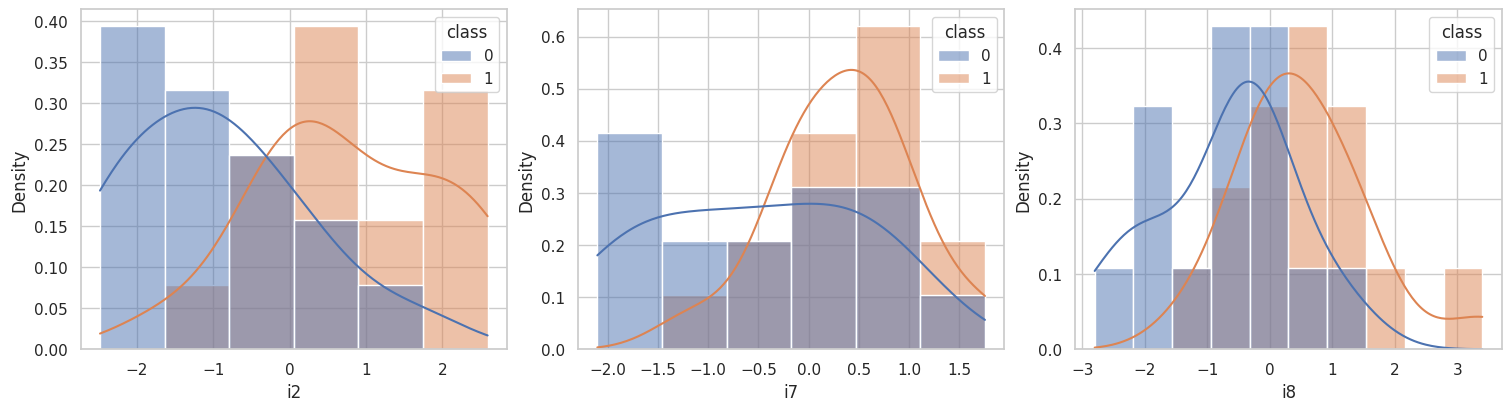

In [3]:
# Combine features and class label
x_informative_labeled = x_informative.copy()
x_informative_labeled.insert(0, "class", y_informative)

# Plot three informative features (`i2`, `i7`, `i8`, where `i` stands for "informative")
# as class-conditional histograms with KDE overlays.
# Each distribution is normalized independently (common_norm=False) to
# highlight shape differences rather than class imbalance.
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
for ax, col in zip(axes, ["i2", "i7", "i8"], strict=False):
    sns.histplot(
        data=x_informative_labeled,
        x=col,
        hue="class",  # color by class
        stat="density",  # show density, not counts
        common_norm=False,  # each class sums to 1; overlaps and shifts are comparable
        kde=True,  # show KDE overlay
        ax=ax,
    )
    ax.set_ylabel("Density")
plt.show()

The figure represents three informative features as class histograms with KDE overlays:

Clear mean shifts or reduced overlap indicate stronger separability; heavy overlap suggests single-feature rules will be error-prone.

Use these panels as a quick sanity check: increasing class_sep should produce cleaner separation; decreasing it should increase overlap.

## Check the effect size ranking

*Background on effect size and Cohen’s d and its interpretation is discussed in `feature_distributions_effect_size.ipynb`.*

In [4]:
ranked_effect_size_df = rank_features_by_effect_size(x_informative, y_informative)
display(ranked_effect_size_df)

,feature,|effect_size|,rank
0,i2,1.456545,1
1,i1,1.298294,2
2,i5,1.273648,3
3,i6,1.206699,4
4,i8,1.151286,5
5,i4,0.996305,6
6,i7,0.975740,7
7,i3,0.660073,8


# Step 2 — Add k irrelevant (noise) features

We now extend the baseline by adding **purely random (irrelevant) features**.
These features carry no signal about the label `y` and should be uncorrelated with the informative block.

We'll add `n_noise = 1200` purely random (irrelevant) noise features drawn from a **normal** distribution with unit scale. `n_informative=8` keeps the true signal fixed across all comparisons, so any change in model performance can be attributed to the amount/type of noise we add.

In [5]:
n_noise_features = 1200  # number of irrelevant features to add
# Dataset configuration for normal noise
cfg_noise_normal = DatasetConfig(
    # n_informative=8 keeps the true signal fixed
    n_informative=8,
    n_noise=n_noise_features,
    class_configs=[
        ClassConfig(n_samples=n_class_samples),  # Class 0
        ClassConfig(n_samples=n_class_samples),  # Class 1
    ],
    class_sep=[1.2],  # Consistent with baseline
    random_state=1908,
)
# Generate a pandas DataFrame with noise features:
Xn, yn, meta_n = generate_dataset(cfg_noise_normal)

print("Informative features:", len(meta_n.informative_idx))
print("Noise features     :", len(meta_n.noise_idx))

In [6]:
# Check that we have 8 informative + 1200 noise features
assert len(meta_n.informative_idx) == 8
assert len(meta_n.noise_idx) == n_noise_features

# Show the first few informative and noise columns for a quick glance
x_noise = Xn.copy()
x_noise.insert(0, "class", yn)
cols_show = ["class"] + [f"i{k}" for k in range(1, 5)] + [f"n{k}" for k in range(1, 5)]
x_noise[cols_show].head(10)

Informative features: 8
Noise features     : 1200


,class,i1,i2,i3,i4,n1,n2,n3,n4
0,0,-0.887323,-1.728232,-0.433686,-1.475208,0.672428,0.775296,-0.075000,0.087924
1,0,-1.005751,-0.670956,1.067461,-1.341802,-0.037173,-0.687763,-1.666362,-1.012635
2,0,-1.120092,-2.472032,-1.137257,0.785498,2.435374,-1.084472,-0.318161,-0.184411
3,0,-0.535320,-2.480069,-2.433523,-0.177608,0.346755,-0.351269,0.501103,0.693386
4,0,-0.592287,-0.942584,-1.585174,-1.492026,-0.506377,-0.228368,-0.831032,-1.312722
5,0,0.123069,-2.283064,0.416130,0.423156,0.645942,-0.601161,-0.518266,0.678294
6,0,-2.191942,-1.242896,0.048579,-0.389918,-0.066735,0.692759,0.674427,-0.050029
7,0,-1.114617,1.680064,0.699556,-1.111995,-0.352025,-0.029952,-0.548047,1.156497
8,0,-1.014007,-0.549308,-0.780158,0.719959,0.093709,1.756713,0.581024,0.370867
9,0,0.397302,0.021571,-1.195669,-0.116389,0.046044,0.201375,0.975967,1.135494


## What do noise features look like?
- **Definition:** Noise (irrelevant) features have **no relationship** to the class label.
- **Visual expectation:** Their class-conditional distributions should **overlap heavily**.
- We'll compare one **informative** feature with one **noise** feature.

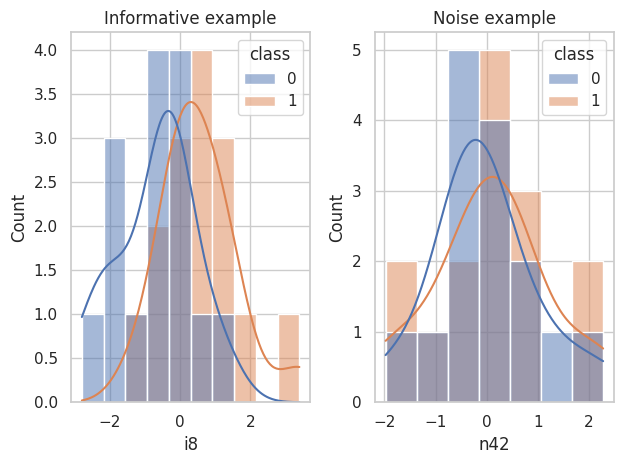

In [7]:
plt.subplot(1, 2, 1)
sns.histplot(data=x_noise, x="i8", hue="class", kde=True)
plt.title("Informative example")

plt.subplot(1, 2, 2)
sns.histplot(data=x_noise, x="n42", hue="class", kde=True)
plt.title("Noise example")
plt.tight_layout()

## How to read the histograms

- **Informative features (`i*`)** will often show **class-conditional shifts** (or different spreads), hinting at separability.
- **Noise features (`n*`)** should look class-agnostic: the overlaid distributions for the two classes (if visualized) should nearly coincide.

With **small `n_samples`**, sampling variation is expected. Some noise features may show apparent class differences by chance. This is normal and illustrates the risk of overfitting in high-dimensional settings. The following plot shows several noise features to visualize this effect.:

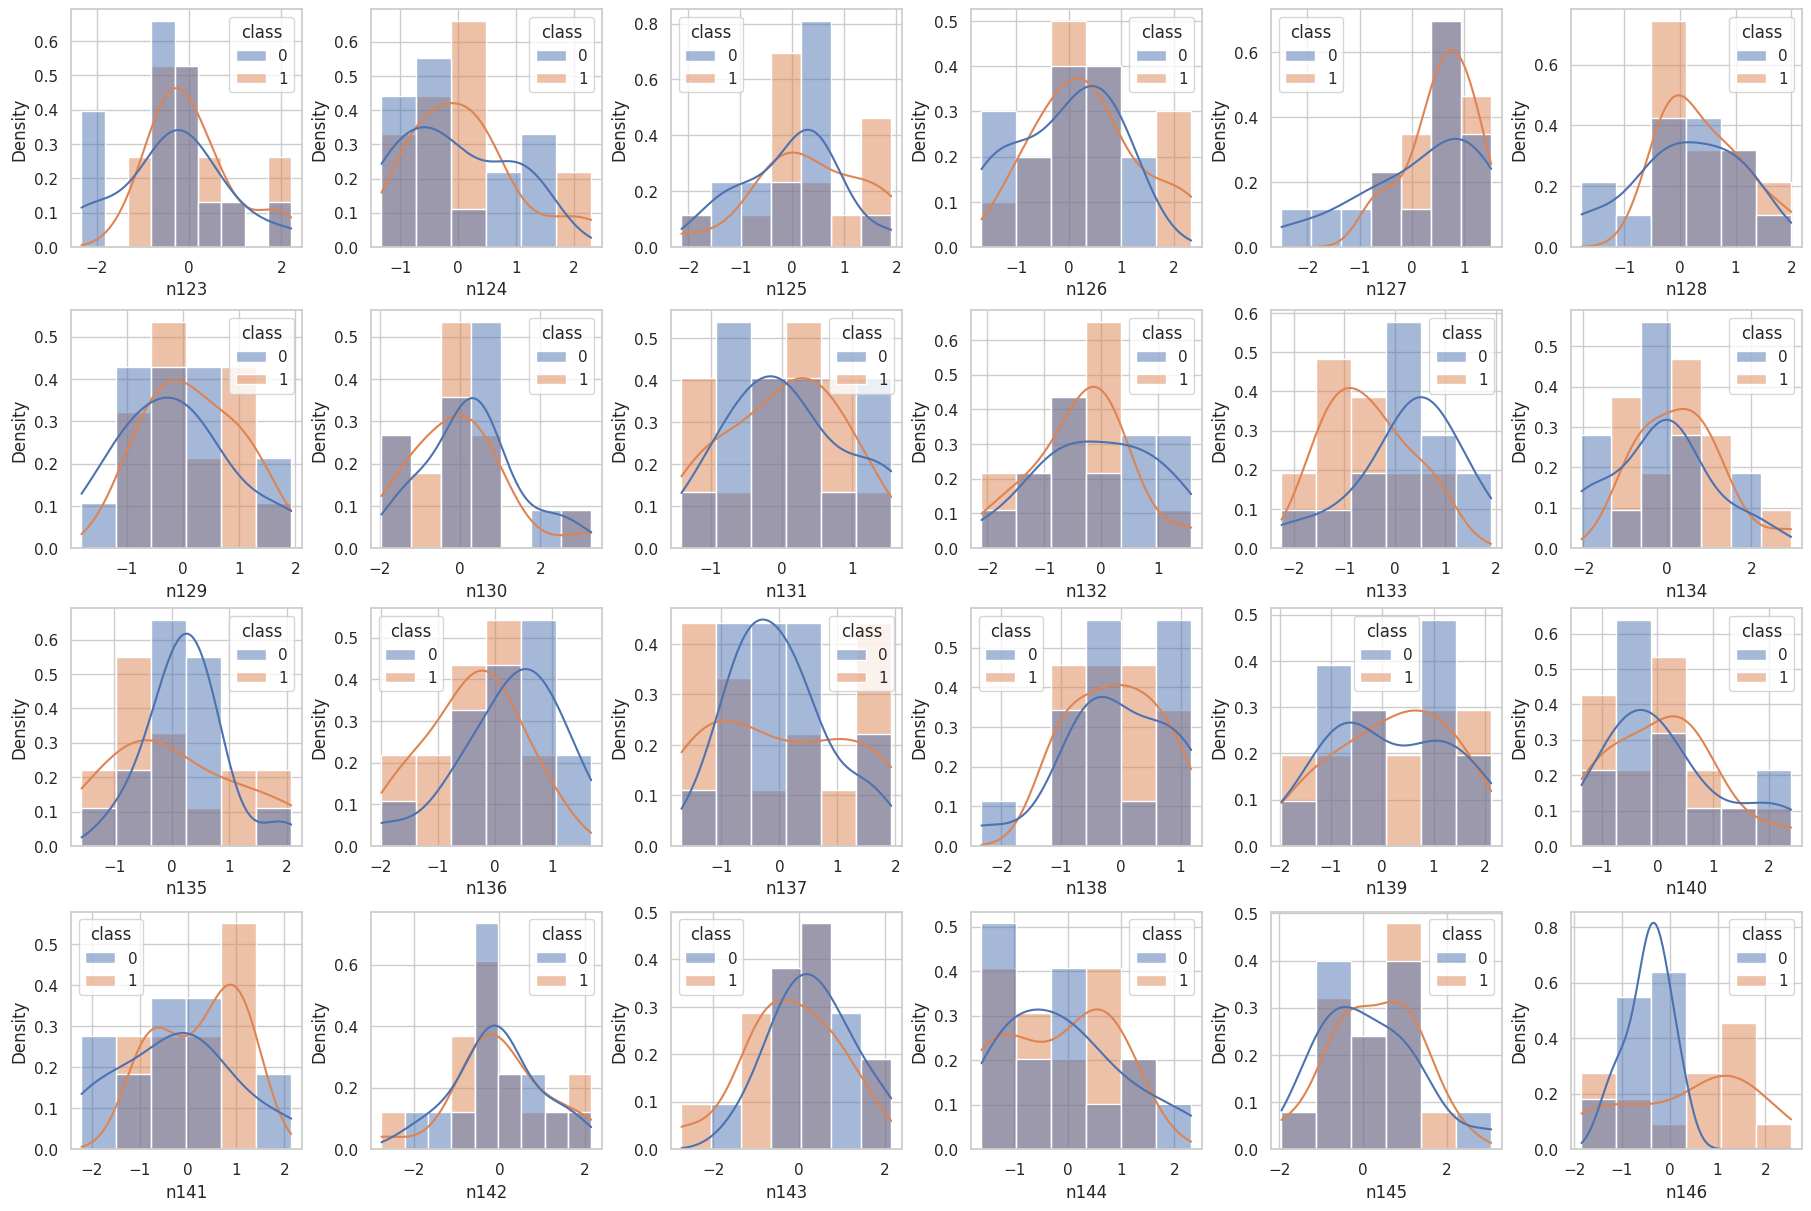

In [8]:
# Plot noise distributions for multiple noise features
fig, axes = plt.subplots(4, 6, figsize=(18, 12), constrained_layout=True)
noise_features_to_plot = [f"n{k}" for k in range(123, 150)]

for ax, col in zip(axes.flatten(), noise_features_to_plot, strict=False):
    sns.histplot(
        data=x_noise,
        x=col,
        hue="class",  # color by class
        stat="density",  # show density, not counts
        common_norm=False,  # each class sums to 1; overlaps and shifts are comparable
        kde=True,  # show KDE overlay
        ax=ax,
    )
    ax.set_ylabel("Density")
plt.show()

**Visual inspection**:
  - Do the noise features always look different from the informative ones in the histograms/KDE plots?
  - Inspect different noise features. Could you spot noise features by eye alone?

Don’t over-interpret minor bumps or slight mean shifts in a single run with **small `n_samples`**. If you want a more stable view, increase `n_samples`.

## Check the effect size ranking with noise features
As visual impressions can be misleading. Let’s **quantify** class separation for two features using **Cohen’s d**.
- Expect **larger d** for informative features.
- Expect **near 0** for noise features.

In [9]:
# Select columns informative i8 and noise n886 and compute the effect-size
ranked_effect_size_df = rank_features_by_effect_size(Xn[["i8", "n886"]], yn)
display(ranked_effect_size_df)

,feature,|effect_size|,rank
0,i8,1.151286,1
1,n886,0.130336,2


We now computes Cohen’s d for the eight informative features and the first eight noise features, ranking them by absolute effect size.

In [10]:
# Compute Cohen's d for the first 8 informative and first 8 noise features
selected_cols = [f"i{k}" for k in range(1, 9)] + [f"n{k}" for k in range(1, 9)]
ranked_effect_size_df = rank_features_by_effect_size(Xn[selected_cols], yn)
display(ranked_effect_size_df)

,feature,|effect_size|,rank
0,i2,1.456545,1
1,i1,1.298294,2
2,i5,1.273648,3
3,i6,1.206699,4
4,i8,1.151286,5
5,i4,0.996305,6
6,i7,0.975740,7
7,i3,0.660073,8
8,n8,0.430182,9
9,n5,0.171323,10


### Interpretation of the effect size ranking
Larger (|d|) ⇒ stronger univariate class separation. Ranking by |d| should list informative features near the top and noise features near the bottom. The top rows are the most discriminative features.
> **Check:** Do `i*` columns dominate the top? Are `n*` near the bottom?

### Increase the number of noise features
Increase the number of included noise features to 1200 and compute Cohen's d for all features, ranking them by absolute effect size.

In [11]:
# Compute Cohen's d for each feature
ranked_effect_size_df = rank_features_by_effect_size(Xn, yn)
print("Top 15 features by |Cohen's d|:")
display(ranked_effect_size_df.iloc[:16, :])  # show the top ranked features

Top 15 features by |Cohen's d|:


,feature,|effect_size|,rank
0,i2,1.456545,1
1,n86,1.408494,2
2,n734,1.395030,3
3,i1,1.298294,4
4,i5,1.273648,5
5,n57,1.222003,6
6,i6,1.206699,7
7,n529,1.200371,8
8,n630,1.177808,9
9,i8,1.151286,10


### Reflection: Does the top-15 list still capture informative features?

**Task**: Count how many of the top 15 features are:
- Informative features (starting with `i`)
- Noise features (starting with `n`)

**Questions**:
- Did the calculated Cohen's d values always match your visual impression?
- Were all informative features ranked higher than noise features?
- Did any noise features appear in the top ranks? If so, why might that happen?

**Expected**: With 8 informative and 1200 noise features, you should find several
noise features in the top 15 purely by chance.

### Check the effect size ranking again (with uniform noise features)
Change the noise distribution to `NoiseDistribution.uniform` at the beginning of Step 2. After changing the noise distribution to `"uniform"` is there any difference in the ranking of cohen's d?

### Why do noise features rank high by |Cohen's d| when the number of features is much higher than the sample size (p ≫ n)?

When the number of features is much larger than the sample size, it is expected that some noise features will rank very high by ∣Cohen’s d∣ — simply due to chance. This is an extreme-value effect. Out of many noisy measurements, some seem "significant" by accident.

* With many features, you are essentially performing many statistical tests at once. Even if every feature is pure noise, some will show high ∣Cohen’s d∣ values by chance . This is known as the 'winner's curse' (selecting the most extreme values
from many candidates leads to overestimation of their true effect).
* Limited sample size increases the impact of variability in your measurements. Extreme values become more likely just due to sampling noise.
* The highest ranking noise features are just a predictable side effect of many features and limited data, not meaningful patterns.

**Good practice**

* Use |Cohen's d| only for initial screening.
* The common 0.2/0.5/0.8 “small/medium/large” rules of thumb are not reliable in high-dimensional biomarker discovery. Prefer context-dependent thresholds over universal rules-of-thumb.

### Biomedical context: Why this matters

As we add more features and reduce the sample size, the ∣Cohen’s d∣ ranking from noise features can increase purely by chance.

Omics datasets (e.g., gene expression, proteomics, methylation) often have **p ≫ n**:
- Thousands of features with few dozens of samples.
- Many features are unrelated to the phenotype—i.e., irrelevant for prediction.

This is why the use of synthetic data is helpful to properly evaluate feature ranking methods and machine learning models in this context:
>**Controlled Experiments**: Synthetic data allows you to create scenarios with only noise or with known signal strengths. This helps you test how often false discoveries occur and how your algorithms behave when p≫n.

>    **Benchmarking**: By knowing exactly which features contain signal and which are pure noise, you can objectively measure your model's ability to distinguish true signals from random fluctuations.

>    **Understanding Pitfalls**: Working with synthetic data provides intuition for why multiple testing and high dimensionality can create misleading results, and helps you design safeguards (like proper validation or regularization).

# Quick Takeaway
- Rule of thumb: Expect some noise features to rank high purely by chance.
- Visually, noise features show strong overlap between classes.
- Effect size (e.g., Cohen’s d) helps screening which features could be informative.
- Synthetic data allows us to control how much noise exists, so we can test how methods behave in high-noise vs. low-noise scenarios.

# Next Steps

In **Lesson 3b: Noise & Spurious Effects**, you will:
- Compare **noise distributions** (Gaussian, Uniform, Laplace).
- Find **spurious correlations**.
- Track **cross-validated performance** as you add more noise features (**p≫n**).

➡️ Continue with: **[`03b_noise_distributions.ipynb`](03b_noise_distributions.ipynb)**